In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [141]:
%cd /content/drive/MyDrive/career-con-2019/data

/content/drive/MyDrive/career-con-2019/data


In [142]:
!pwd

/content/drive/MyDrive/career-con-2019/data


In [143]:
print(os.listdir("/content/drive/MyDrive/career-con-2019/data"))

['X_train.csv', 'X_test.csv', 'kaggle.json', 'X_test.csv.zip', 'y_train.csv', 'sample_submission.csv', 'X_train.csv.zip']


In [144]:
X_train = pd.read_csv('/content/drive/MyDrive/career-con-2019/data/X_train.csv')
y_train = pd.read_csv('/content/drive/MyDrive/career-con-2019/data/y_train.csv')
X_test = pd.read_csv('/content/drive/MyDrive/career-con-2019/data/X_test.csv')

In [145]:
X_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [146]:
X_train.tail(3)

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
487677,3809_125,3809,125,0.62891,-0.76861,-0.084345,0.081178,-0.031184,-0.003961,-0.13894,2.70480,4.2622,-8.1443
487678,3809_126,3809,126,0.62903,-0.76850,-0.084414,0.081231,-0.069153,0.013229,-0.13021,2.54100,4.7130,-9.4435
487679,3809_127,3809,127,0.62915,-0.76839,-0.084441,0.081284,-0.042769,0.034049,-0.12580,0.82391,4.2751,-10.4980


In [147]:
X_test.head(3)

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,0.91208,-0.38193,-0.050618,0.14028,-0.060205,0.071286,-0.18787,0.29492,2.8027,-9.6816
1,0_1,0,1,0.91220,-0.38165,-0.050573,0.14028,-0.033486,0.060210,-0.18206,0.14944,2.5408,-9.8521
2,0_2,0,2,0.91228,-0.38143,-0.050586,0.14032,-0.029686,0.029476,-0.18441,-0.49741,2.5853,-9.3835


In [148]:
X_test.tail(3)

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
488445,3815_125,3815,125,0.89521,-0.42019,-0.056343,0.13734,0.033571,0.019868,-0.007203,0.44106,3.2110,-9.3700
488446,3815_126,3815,126,0.89522,-0.42019,-0.056300,0.13730,0.046988,0.015570,0.001514,-0.25947,2.8634,-9.8546
488447,3815_127,3815,127,0.89523,-0.42019,-0.056262,0.13723,0.058816,0.006849,-0.003825,0.22418,2.5159,-10.5870


In [149]:
y_train.head()

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


In [150]:
y_train.tail()

,series_id,group_id,surface
3805,3805,55,tiled
3806,3806,67,wood
3807,3807,48,fine_concrete
3808,3808,54,tiled
3809,3809,56,soft_pvc


In [151]:
print("shape of x_train is: {}\nshape of x_test is: {}\nshape of y_train{}".format(X_train.shape, X_test.shape, y_train.shape))

shape of x_train is: (487680, 13)
shape of x_test is: (488448, 13)
shape of y_train(3810, 3)


In [152]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
X_train = pd.merge(X_train, y_train, on='series_id')
X_train['surface'] = le.fit_transform(X_train['surface'])

    
X_test['series_id'] = X_test['series_id']+3810
X_test['group_id'] = 0
X_test['surface'] = 0
X_train = pd.concat([X_train, X_test])
X_train.reset_index(drop=True, inplace=True)  

In [153]:
X_train.shape

(976128, 15)

In [154]:
cols = list(X_train.columns.values)
cols.remove('orientation_W')
cols.insert(3,'orientation_W')
X_train = X_train[cols]

In [155]:
X_train.head(3)


,row_id,series_id,measurement_number,orientation_W,orientation_X,orientation_Y,orientation_Z,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,group_id,surface
0,0_0,0,0,-0.10597,-0.75853,-0.63435,-0.10488,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,13,2
1,0_1,0,1,-0.10600,-0.75853,-0.63434,-0.10490,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,13,2
2,0_2,0,2,-0.10597,-0.75853,-0.63435,-0.10492,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,13,2


In [156]:
num_meas = 128
num_series = X_train['series_id'].nunique()

In [157]:
num_series

7626

In [158]:
def q_to_angle(q_val):
    #We assume q_val is in this format: [qw, q1, q2, q3]
    #And the quaternion is normalized
    roll = np.arctan2(2*(q_val[0]*q_val[1] + q_val[2]*q_val[3]),1 - 2*(q_val[1]*q_val[1] + q_val[2]*q_val[2]))
    pitch = np.arcsin(2*(q_val[0]*q_val[2] - q_val[3]*q_val[1]))
    yaw = np.arctan2(2*(q_val[0]*q_val[3] + q_val[1]*q_val[2]),1 - 2*(q_val[2]*q_val[2] + q_val[3]*q_val[3]))
    return np.array([roll, pitch, yaw])

In [159]:
quat_arr = np.array(X_train[['orientation_W','orientation_X','orientation_Y','orientation_Z']])
euler_arr = np.zeros([quat_arr.shape[0],3])
for n,arr in enumerate(quat_arr):
    euler_arr[n] = q_to_angle(arr)

In [160]:
euler_arr.shape

(976128, 3)

In [161]:
X_train['roll'] = euler_arr[:,0]
X_train['pitch'] = euler_arr[:,1]
X_train['yaw'] = euler_arr[:,2]

In [162]:
cols = list(X_train.columns.values)
cols.remove('group_id')
cols.append('group_id')
cols.remove('surface')
cols.append('surface')
X_train = X_train[cols]

In [163]:
feat_cols = ['roll','pitch','yaw','angular_velocity_X','angular_velocity_Y','angular_velocity_Z','linear_acceleration_X','linear_acceleration_Y','linear_acceleration_Z']
feat_array = np.array(X_train[feat_cols])
feat_array = np.reshape(feat_array,[num_series,128,len(feat_cols)])
group_array = np.array(X_train['group_id'])
group_array = np.reshape(group_array,[num_series,128])
group_array = group_array[:,0]
target_array = np.array(X_train['surface'])
target_array = np.reshape(target_array,[num_series,128])
target_array = target_array[:,0]

In [164]:
print("shape of feat_array is: {}\nshape of group_array is: {}\nshape of target_array{}".format(feat_array.shape, group_array.shape, target_array.shape))

shape of feat_array is: (7626, 128, 9)
shape of group_array is: (7626,)
shape of target_array(7626,)


In [165]:
delta_cols = ['roll','pitch','yaw']
for dc in delta_cols:
    iia = feat_cols.index(dc)
    np_arr = feat_array[:,:,iia]
    roll_arr = np.copy(np_arr)
    roll_arr[:,1:] = roll_arr[:,:-1]
    np_arr = np_arr - roll_arr
    feat_array[:,:,iia] = np_arr

In [166]:
norm_cols = ['linear_acceleration_X','linear_acceleration_Y','linear_acceleration_Z','angular_velocity_X','angular_velocity_Y','angular_velocity_Z']
for norm in norm_cols:
    iia = feat_cols.index(norm)
    np_arr = feat_array[:,:,iia]
    mean_arr = np.mean(np_arr,1)
    mean_arr = np.expand_dims(mean_arr,1)
    mean_arr = np.repeat(mean_arr,num_meas,1)
    np_arr = np_arr - mean_arr
    feat_array[:,:,iia] = np_arr

In [167]:
num_sensor = feat_array.shape[2]

for i in range(num_sensor):
    mean_s = np.mean(feat_array[:,:,i])
    sd_s = np.std(feat_array[:,:,i])
    feat_array[:,:,i] = (feat_array[:,:,i]-mean_s)/sd_s

In [168]:
from keras.layers import Input,Dense, Dropout, BatchNormalization, SeparableConv1D, Reshape, LSTM, DepthwiseConv2D,AveragePooling2D, CuDNNLSTM, Concatenate
from keras.models import Model
from keras.backend import squeeze
from keras.regularizers import l2
from keras.layers import Conv1D

In [169]:
kr = None
num_groups = np.unique(group_array).shape[0]
num_surfaces = np.unique(target_array).shape[0]

In [170]:
def CNN1D_NET(dp):
    inputs_t = Input(shape=(128,len(feat_cols)))
    x = Conv1D(32,8,2,'same',activation='relu',kernel_regularizer=kr)(inputs_t)
    x = Dropout(dp)(x)
    x = Conv1D(64,8,4,'same',activation='relu',kernel_regularizer=kr)(x)
    x = Dropout(dp)(x)
    x = Conv1D(128,8,4,'same',activation='relu',kernel_regularizer=kr)(x)
    x = Dropout(dp)(x)
    x = Conv1D(256,8,4,'same',activation='relu',kernel_regularizer=kr)(x)
    x = Reshape((256,))(x)
    # x = Dropout(dp)(x)
    # x = Dense(256, activation='relu',kernel_regularizer=kr)(x)
    # x = Dropout(dp)(x)
    # x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu',kernel_regularizer=kr)(x)
    # x = Dense(32, activation='relu')(x)

    # z = Dense(16, activation='relu')(x)
    predictions = Dense(num_surfaces, activation='softmax')(x)
    model = Model(inputs=inputs_t, outputs=predictions)
    model.compile(optimizer='Nadam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [171]:
cnnm = CNN1D_NET(0.5)
cnnm.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 9)]          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 64, 32)            2336      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64, 32)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 16, 64)            16448     
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 64)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 4, 128)            65664     
_________________________________________________________________
dropout_5 (Dropout)          (None, 4, 128)            0   

In [172]:
tx_data = feat_array[:3000]
tr_data = target_array[:3000]
tacc_data = feat_array[3000:3810]
tracc_data = target_array[3000:3810]

# test_data = feat_array[3810:]

In [173]:
hist = cnnm.fit(x=tx_data, y=tr_data, batch_size=8, epochs=350, verbose=1)

Epoch 1/350
375/375 [==============================] - 4s 8ms/step - loss: 1.9084 - accuracy: 0.2847
Epoch 2/350
375/375 [==============================] - 3s 8ms/step - loss: 1.6454 - accuracy: 0.3927
Epoch 3/350
375/375 [==============================] - 3s 7ms/step - loss: 1.4380 - accuracy: 0.4553
Epoch 4/350
375/375 [==============================] - 3s 8ms/step - loss: 1.2978 - accuracy: 0.5160
Epoch 5/350
375/375 [==============================] - 3s 7ms/step - loss: 1.2334 - accuracy: 0.5203
Epoch 6/350
375/375 [==============================] - 3s 8ms/step - loss: 1.1732 - accuracy: 0.5517
Epoch 7/350
375/375 [==============================] - 3s 7ms/step - loss: 1.1633 - accuracy: 0.5567
Epoch 8/350
375/375 [==============================] - 3s 7ms/step - loss: 1.1112 - accuracy: 0.5750
Epoch 9/350
375/375 [==============================] - 3s 7ms/step - loss: 1.0559 - accuracy: 0.5913
Epoch 10/350
375/375 [==============================] - 3s 8ms/step - loss: 1.0478 - accura

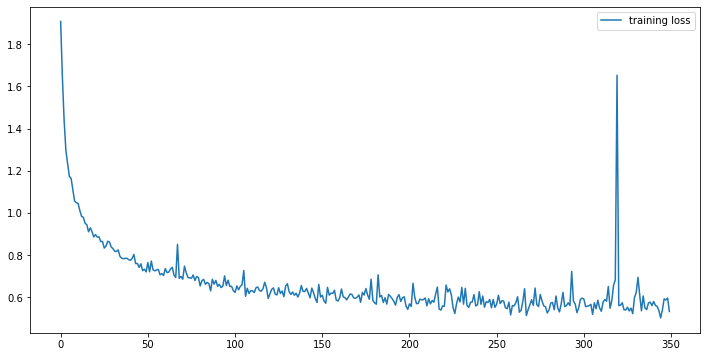

In [174]:
plt.figure(figsize=(12, 6))
plt.plot(hist.history['loss'], label= 'training loss')
plt.legend();

''

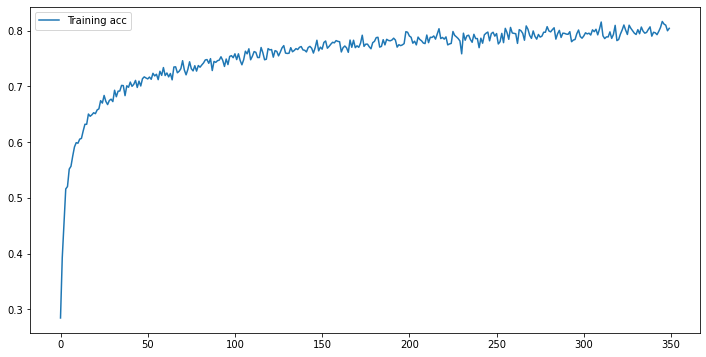

In [175]:
plt.figure(figsize=(12, 6))
plt.plot(hist.history['accuracy'], label="Training acc")
plt.legend()
;

In [176]:
cnnm.evaluate(tacc_data, tracc_data, verbose=2)

26/26 - 0s - loss: 0.8985 - accuracy: 0.8025


[0.8985244631767273, 0.8024691343307495]

In [189]:
pr = cnnm.predict(tacc_data[:3])

In [191]:
pr

array([[0.0000000e+00, 3.0096881e-22, 6.9536096e-01, 0.0000000e+00,
        3.0463454e-01, 3.8871934e-31, 4.5097536e-06, 0.0000000e+00,
        2.9676289e-16],
       [3.4389575e-07, 2.4007370e-04, 3.0581884e-02, 0.0000000e+00,
        9.6917558e-01, 6.3590413e-12, 8.0533908e-08, 4.7036966e-08,
        1.9212710e-06],
       [2.7894593e-11, 9.9743903e-01, 3.7222520e-18, 0.0000000e+00,
        2.0262308e-03, 1.0443798e-05, 1.7841803e-31, 5.2308489e-04,
        1.1304263e-06]], dtype=float32)

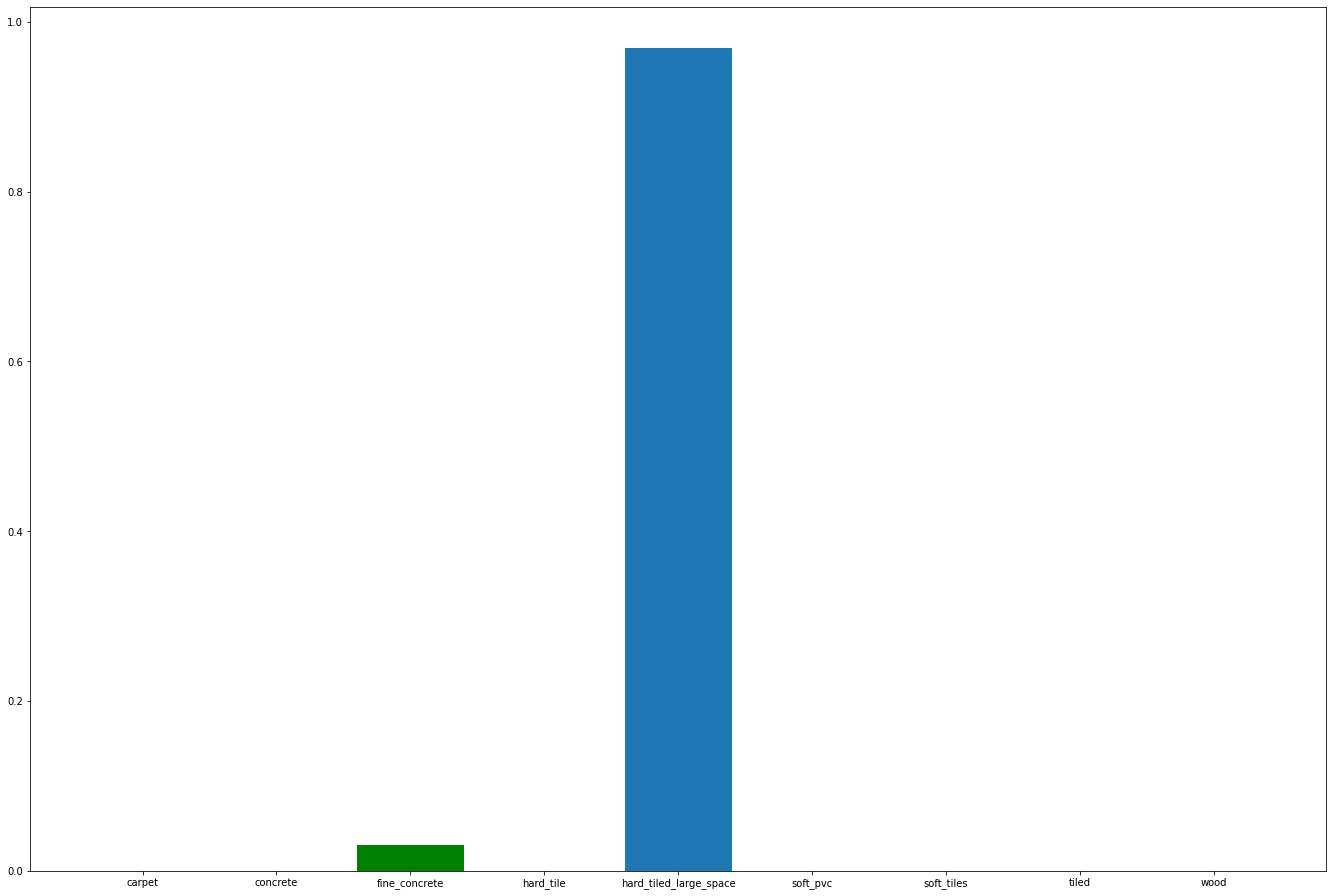

In [199]:
# The green bar is correct surface.
fig = plt.figure()
ax = fig.add_axes([0,0,3,3])
langs = ['carpet', 'concrete', 'fine_concrete','hard_tile', 'hard_tiled_large_space', 'soft_pvc', 'soft_tiles', 'tiled', 'wood']
prob = pr[1,:]
ax.bar(langs, prob)
ax.bar(langs[tracc_data[1]], prob[tracc_data[1]], color='g')
  
plt.show()